In [45]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import RidgeCV
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt



In [117]:
# Import the data
df = pd.read_csv('/Users/gadimg/Library/Mobile Documents/com~apple~CloudDocs/PhD dis/third/Data/Merged_data/Full_with_monthly_no_other_crypto.csv', parse_dates=['Date'], dayfirst=True)

# Drop unnecessary columns and handle missing data
df = df.drop(columns=['Date', 'WETH_Price'])
df.replace(0, 1e-9, inplace=True)  # Handle zeros for percent change

# Calculate percentage changes
df_returns = df.pct_change().dropna()

# Normalize the data
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_returns), columns=df_returns.columns)

# Prepare the data
Y = df_normalized['ETH_Price'].values
X = df_normalized.drop(columns=['ETH_Price']).values



In [118]:
# Number of observations
n = len(df_normalized)
start = n - 100
predictionsLasso = []
coefficients = []

# Recursive window prediction with time series cross-validation
for i in range(start, n):
    # Define the training data
    X_train = X[:i]
    y_train = Y[:i]

    # TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    model = LassoCV(cv=tscv, normalize=False, random_state=0)  # Set normalize to False since we've already normalized
    model.fit(X_train, y_train)

    # Save coefficients
    coefficients.append(model.coef_)

    # Make prediction
    y_pred = model.predict(X[i].reshape(1, -1))
    predictionsLasso.append(y_pred[0])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y[start:], predictionsLasso))
print(f"RMSE: {rmse}")
actuals = Y[start:]

# Calculate MAE
mae = mean_absolute_error(actuals, predictionsLasso)
print(f"MAE: {mae}")

# Calculate MDA
actuals_array = np.array(actuals)
predictionsLasso_array = np.array(predictionsLasso)
correct_direction = np.sign(actuals_array[1:] - actuals_array[:-1]) == np.sign(predictionsLasso_array[1:] - predictionsLasso_array[:-1])
mda = np.mean(correct_direction) * 100
print(f"MDA: {mda}%")

# Convert coefficients to a DataFrame for better visualization
coef_df = pd.DataFrame(coefficients, columns=df.drop(columns=['ETH_Price']).columns)
print(coef_df)


RMSE: 0.21554796341339127
MAE: 0.1485734101828746
MDA: 85.85858585858585%
    ETH_Volume  BTC_Price  BTC_Volume  LINK_number_of_transfers  \
0     0.030285   0.353365   -0.006688                      -0.0   
1     0.030082   0.353465   -0.006499                      -0.0   
2     0.030082   0.353466   -0.006496                      -0.0   
3     0.029941   0.353759   -0.006407                      -0.0   
4     0.028931   0.355472   -0.007022                      -0.0   
..         ...        ...         ...                       ...   
95    0.000000   0.355171   -0.000000                      -0.0   
96    0.000000   0.355186   -0.000000                      -0.0   
97    0.000000   0.355367   -0.000000                      -0.0   
98    0.000000   0.355398   -0.000000                      -0.0   
99    0.000000   0.355347   -0.000000                      -0.0   

    LINK_on_chain_volume  LINK_Price  LINK_Volume  \
0                   -0.0    0.336472         -0.0   
1              

In [27]:
last_coef = coef_df.iloc[-1]

# Get the sorted column names based on the absolute values of the coefficients from the last row
sorted_columns = last_coef.abs().sort_values(ascending=False).index

# Reorder the entire DataFrame based on these sorted column names
sorted_coef_df = coef_df[sorted_columns]

# Export to CSV
sorted_coef_df.to_csv('/Users/gadimg/Library/Mobile Documents/com~apple~CloudDocs/PhD dis/third/Results/pct_change_results/Lasso_test2.csv', index=False)


In [119]:
# Define the starting point and the number of predictions
#Ridge regression with cryptos
n = len(df_normalized) #add when need lagged one
start = n - 100
predictionsRidge = []
coefficients = []

# Define alphas (the regularization strengths to try)
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# Recursive window prediction
for i in range(start, n):
    # Define the training data
    X_train = X[:i]
    y_train = Y[:i]
    tscv = TimeSeriesSplit(n_splits=5)
    # Define Ridge with 10-fold CV
    model = RidgeCV(alphas=alphas, cv=tscv, normalize=False)  # Set normalize to False since we've already normalized
    model.fit(X_train, y_train)
    
    # Save coefficients
    coefficients.append(model.coef_)
    
    # Make prediction
    y_pred = model.predict(X[i].reshape(1, -1))
    predictionsRidge.append(y_pred[0])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y[start:], predictionsRidge))
print(f"RMSE: {rmse}")

actuals = Y[start:]

# Calculate MAE
mae = mean_absolute_error(actuals, predictionsRidge)
print(f"MAE: {mae}")

# Calculate MDA
actuals_array = np.array(actuals)
predictionsRidge_array = np.array(predictionsRidge)
correct_direction = np.sign(actuals_array[1:] - actuals_array[:-1]) == np.sign(predictionsRidge_array[1:] - predictionsRidge_array[:-1])
mda = np.mean(correct_direction) * 100
print(f"MDA: {mda}%")

# Convert coefficients to a DataFrame for better visualization
coef_df = pd.DataFrame(coefficients, columns=df.drop(columns=['ETH_Price']).columns)
print(coef_df)

RMSE: 0.25726497033286033
MAE: 0.20698559914630782
MDA: 75.75757575757575%
    ETH_Volume  BTC_Price  BTC_Volume  LINK_number_of_transfers  \
0     0.220423   0.257517   -0.107404                 -0.001821   
1     0.220416   0.257504   -0.107416                 -0.001825   
2     0.220446   0.257500   -0.107344                 -0.001830   
3     0.220505   0.257637   -0.107089                 -0.001806   
4     0.219855   0.258181   -0.107312                 -0.002536   
..         ...        ...         ...                       ...   
95    0.191219   0.258363   -0.104690                 -0.007136   
96    0.192508   0.258306   -0.106848                 -0.007224   
97    0.192723   0.258284   -0.106496                 -0.007079   
98    0.192827   0.258266   -0.106409                 -0.007125   
99    0.192624   0.258214   -0.106522                 -0.007107   

    LINK_on_chain_volume  LINK_Price  LINK_Volume  \
0              -0.017353    0.300865     0.021908   
1             

In [114]:
#post-lasso without Lags
from sklearn.linear_model import LinearRegression
n = len(df_normalized)
start = n - 100

non_zero_mask = coef_df.iloc[-1] != 0

feature_columns = df_normalized.drop(columns=['ETH_Price']).columns
significant_columns = feature_columns[non_zero_mask] 

X_significant = X[:, non_zero_mask]
# Prepare to predict with OLS on the filtered X
ols_predictions = []
ols_model = LinearRegression()

# Recursive window prediction using the filtered features
for i in range(start, n):
    X_train_significant = X_significant[:i]
    y_train = Y[:i]
    
    # Fit the OLS model
    ols_model.fit(X_train_significant, y_train)
    
    # Make prediction using the OLS model
    y_pred_ols = ols_model.predict(X_significant[[i]])  # Ensure 2D input for the prediction
    ols_predictions.append(y_pred_ols[0])

# Calculate RMSE for the OLS predictions
ols_rmse = np.sqrt(mean_squared_error(Y[start:], ols_predictions))
print(f"Post-Lasso OLS RMSE: {ols_rmse}")

actuals = Y[start:]

# Calculate MAE
mae = mean_absolute_error(actuals, ols_predictions)
print(f"MAE: {mae}")

# Calculate MDA
actuals_array = np.array(actuals)
predictionsOLS_array = np.array(ols_predictions)
correct_direction = np.sign(actuals_array[1:] - actuals_array[:-1]) == np.sign(predictionsOLS_array[1:] - predictionsOLS_array[:-1])
mda = np.mean(correct_direction) * 100
print(f"MDA: {mda}%")

# Export the final OLS coefficients alongside their feature names to a # ...

# Export the final OLS coefficients alongside their feature names to a CSV:
final_ols_coef_df = pd.DataFrame({'Coefficient': ols_model.coef_}, index=significant_columns)


Post-Lasso OLS RMSE: 0.18911130773075166
MAE: 0.14166399401373314
MDA: 85.85858585858585%


In [37]:
# Export the final OLS coefficients alongside their feature names to a CSV:
final_ols_coef_df = pd.DataFrame({'Coefficient': ols_model.coef_}, index=significant_columns)

# Calculate the absolute values and sort by them in descending order
final_ols_coef_df['Absolute_Coefficient'] = final_ols_coef_df['Coefficient'].abs()
sorted_final_ols_coef_df = final_ols_coef_df.sort_values('Absolute_Coefficient', ascending=False).drop('Absolute_Coefficient', axis=1)

# Export the sorted DataFrame to CSV
sorted_final_ols_coef_df.to_csv('/Users/gadimg/Library/Mobile Documents/com~apple~CloudDocs/PhD dis/third/Results/pct_change_results/postLasso_withOUTcrypto_pct_change.csv', index=True, header=True)



In [115]:
#getting the p-values after for post lasso, full dataset
import statsmodels.api as sm

# Assuming 'significant_columns' contains the names of the predictors selected by Lasso
X_significant = df_normalized[significant_columns]
Y = df_normalized['ETH_Price']

# Add a constant to the model (intercept)
X_significant = sm.add_constant(X_significant)

# Fit the OLS model using statsmodels
ols_model = sm.OLS(Y, X_significant).fit()

# Print out the summary which includes the p-values
print(ols_model.summary())

# If you need to access the p-values directly
p_values = ols_model.pvalues
print(p_values)

# To export the coefficients and p-values to a CSV:
coeff_pvalues_df = pd.DataFrame({
    'Coefficient': ols_model.params,
    'P-Value': ols_model.pvalues
})
#coeff_pvalues_df.to_csv('/Users/gadimg/Library/Mobile Documents/com~apple~CloudDocs/PhD dis/third/Results/pct_change_results/postLasso_pct_change_p_values.csv', index=True)


                            OLS Regression Results                            
Dep. Variable:              ETH_Price   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     463.2
Date:                Sun, 11 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:30:54   Log-Likelihood:                -759.77
No. Observations:                1162   AIC:                             1540.
Df Residuals:                    1152   BIC:                             1590.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.589e-18      0.014  -5.54e-16      

In [8]:
X_significant

,const,BTC_Price,LINK_Price,WBTC_Price,MATIC_Price,TRX_Close,DOT_Close,ADA_Close,BNB_Close,SOL_Close
0,1.0,-0.753813,-2.492531,-0.898223,-0.967097,-2.521512,-0.176143,-1.424152,-0.863420,-1.218470
1,1.0,0.188220,2.702549,0.637723,0.590605,0.672509,9.258711,0.193629,0.034897,0.307163
2,1.0,-0.083347,-0.873470,-0.217642,-0.504259,-0.636028,-1.948252,-0.587783,-0.380268,1.339936
3,1.0,0.238684,-0.007819,0.283864,1.356140,0.562697,2.625932,0.410274,0.584606,0.034288
4,1.0,-1.068750,-1.124549,-0.796810,-1.091710,-1.764557,3.287260,-1.724320,-1.022605,-0.397213
...,...,...,...,...,...,...,...,...,...,...
1157,1.0,1.444144,0.257284,1.483932,0.420402,0.503195,0.105254,0.282939,0.404313,1.258420
1158,1.0,-0.148081,-0.494695,-0.116464,-0.439378,-0.128953,-0.519991,-0.368152,-0.345964,-0.074822
1159,1.0,-0.131455,0.051164,-0.169993,-0.281109,0.111015,-0.116361,-0.314426,-0.165102,-0.369791
1160,1.0,0.369443,-0.138068,0.375931,0.097424,0.135430,-0.067600,0.231237,-0.002641,0.840888


In [39]:
from sklearn.linear_model import LinearRegression

# Initialize lists to store predictions and coefficients
ols_predictions = []
ols_coefficients = []
n = len(df_normalized)
start = n - 100
# Recursive window prediction
for i in range(start, n):
    # Define the training data
    X_train = X[:i]
    y_train = Y[:i]
    
    # Define and fit the OLS model
    ols_model = LinearRegression()
    ols_model.fit(X_train, y_train)
    
    # Save coefficients
    ols_coefficients.append(ols_model.coef_)
    
    # Make prediction
    y_pred_ols = ols_model.predict(X[i].reshape(1, -1))
    ols_predictions.append(y_pred_ols[0])

# Calculate RMSE for OLS predictions
ols_rmse = np.sqrt(mean_squared_error(Y[start:], ols_predictions))
print(f"OLS RMSE: {ols_rmse}")

actuals = Y[start:]

# Calculate MAE
mae = mean_absolute_error(actuals, ols_predictions)
print(f"MAE: {mae}")

# Calculate MDA
actuals_array = np.array(actuals)
predictionsOLS_array = np.array(ols_predictions)
correct_direction = np.sign(actuals_array[1:] - actuals_array[:-1]) == np.sign(predictionsOLS_array[1:] - predictionsOLS_array[:-1])
mda = np.mean(correct_direction) * 100
print(f"MDA: {mda}%")

# Convert OLS coefficients to a DataFrame for better visualization
ols_coef_df = pd.DataFrame(ols_coefficients, columns=df.drop(columns=['ETH_Price']).columns)
print(ols_coef_df)


OLS RMSE: 0.3324955139587656
MAE: 0.26160605541418236
MDA: 67.67676767676768%
    ETH_Volume  BTC_Price  BTC_Volume  LINK_number_of_transfers  \
0     0.405561   0.446521   -0.207346                 -0.000239   
1     0.405523   0.446369   -0.207421                 -0.000259   
2     0.405552   0.446360   -0.207287                 -0.000270   
3     0.405791   0.446905   -0.206647                 -0.000225   
4     0.404195   0.449226   -0.207311                 -0.001158   
..         ...        ...         ...                       ...   
95    0.317922   0.436848   -0.202894                 -0.008033   
96    0.318811   0.436816   -0.203723                 -0.008063   
97    0.319107   0.436925   -0.203094                 -0.007910   
98    0.319298   0.436863   -0.202928                 -0.008014   
99    0.318879   0.436839   -0.203187                 -0.007988   

    LINK_on_chain_volume  LINK_Price  LINK_Volume  \
0              -0.020056    0.309888     0.064940   
1          

In [21]:
#this did not yield the expected results
def add_lags(df, n_lags):
    df_lagged = df.copy()
    for column in df.columns:
        for lag in range(1, n_lags + 1):
            df_lagged[f'{column}_lag{lag}'] = df[column].shift(lag)
    # It will drop the rows where at least one element is missing
    df_lagged = df_lagged.dropna()
    return df_lagged

# Number of lags to add
n_lags = 7

# Add lags to the data (excluding the 'ETH_Price' column)
df_lagged = add_lags(df_normalized.drop(columns=['ETH_Price']), n_lags)

# Align the 'ETH_Price' with the lagged features
# Note that the shift is no longer needed since we are aligning by dropping rows from both the feature and target datasets
df_lagged = df_lagged.reset_index(drop=True)
df_target_aligned = df_normalized['ETH_Price'].iloc[n_lags:].reset_index(drop=True)

# Ensure df_lagged and df_target_aligned have the same length
assert len(df_lagged) == len(df_target_aligned), "The features and target are not aligned."

# Update Y and X with the aligned data
Y = df_target_aligned.values
X = df_lagged.values


<ipython-input-21-32ca52ca0879>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged[f'{column}_lag{lag}'] = df[column].shift(lag)
<ipython-input-21-32ca52ca0879>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged[f'{column}_lag{lag}'] = df[column].shift(lag)
<ipython-input-21-32ca52ca0879>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

<ipython-input-21-32ca52ca0879>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged[f'{column}_lag{lag}'] = df[column].shift(lag)
<ipython-input-21-32ca52ca0879>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged[f'{column}_lag{lag}'] = df[column].shift(lag)
<ipython-input-21-32ca52ca0879>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

In [24]:
n = len(df_lagged)

# Doing the prediction with all the lags, LASSO
#basically none of the lags were effective at all, so will delete this from the paper
start = n - 100
predictions = []
coefficients = []

# Recursive window prediction
for i in range(start, n):
    # Define the training data
    X_train = X[:i]
    y_train = Y[:i]
    tscv = TimeSeriesSplit(n_splits=5)
    # Define Lasso with 5-fold CV
    model = LassoCV(cv=tscv, random_state=0)  # normalize parameter is deprecated
    model.fit(X_train, y_train)
    
    # Save coefficients
    coefficients.append(model.coef_)
    
    # Make prediction
    # Use double brackets to maintain the 2D structure expected by the predict method
    y_pred = model.predict(X[[i]])
    predictions.append(y_pred[0])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y[start:], predictions))
print(f"RMSE: {rmse}")

actuals = Y[start:]

# Calculate MAE
mae = mean_absolute_error(actuals, predictions)
print(f"MAE: {mae}")

# Calculate MDA
actuals_array = np.array(actuals)
predictionsLasso_array = np.array(predictions)
correct_direction = np.sign(actuals_array[1:] - actuals_array[:-1]) == np.sign(predictionsLasso_array[1:] - predictionsLasso_array[:-1])
mda = np.mean(correct_direction) * 100
print(f"MDA: {mda}%")

# Convert coefficients to a DataFrame for better visualization
# Use the correct column names from the lagged DataFrame
coef_df = pd.DataFrame(coefficients, columns=df_lagged.columns)
print(coef_df)

/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036597229759943006, tolerance: 0.024179168971507993
  model = cd_fast.enet_coordinate_descent(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11636724392440101, tolerance: 0.0731672883428463
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10009829915289714, tolerance: 0.07332161065361116
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-

/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0809965868590723, tolerance: 0.07426809188037707
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09895311712792676, tolerance: 0.07441413813673853
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07438379634851855, tolerance: 0.05755711303431392
  model = cd_fast.enet_coordinate_descent(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-pa

/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06496861205329552, tolerance: 0.06039080487537683
  model = cd_fast.enet_coordinate_descent(


RMSE: 0.18636981639005254
MAE: 0.1378208837349675
MDA: 85.85858585858585%
    ETH_Volume  BTC_Price  BTC_Volume  LINK_number_of_transfers  \
0          0.0   0.318740        -0.0                      -0.0   
1          0.0   0.319027        -0.0                      -0.0   
2          0.0   0.319047        -0.0                      -0.0   
3          0.0   0.318196        -0.0                      -0.0   
4          0.0   0.320140        -0.0                      -0.0   
..         ...        ...         ...                       ...   
95         0.0   0.322117        -0.0                      -0.0   
96         0.0   0.322886        -0.0                      -0.0   
97         0.0   0.323638        -0.0                      -0.0   
98         0.0   0.323650        -0.0                      -0.0   
99         0.0   0.322798        -0.0                      -0.0   

    LINK_on_chain_volume  LINK_Price  LINK_Volume  \
0                   -0.0    0.256683         -0.0   
1              

In [25]:
last_coef = coef_df.iloc[-1]

# Get the sorted column names based on the absolute values of the coefficients from the last row
sorted_columns = last_coef.abs().sort_values(ascending=False).index

# Reorder the entire DataFrame based on these sorted column names
sorted_coef_df = coef_df[sorted_columns]

# Export to CSV
sorted_coef_df.to_csv('/Users/gadimg/Library/Mobile Documents/com~apple~CloudDocs/PhD dis/third/Results/pct_change_results/Lasso_lags.csv', index=False)


In [63]:
from statsmodels.tsa.ar_model import AutoReg
n = len(df_normalized)
# Your Y and start are already defined from the Lasso part
# Recursive window prediction for AR model, straight up with 7 lags
start = n - 100

ar_predictions = []

for i in range(start, n):
    # Define the training data up to point i
    y_train_ar = Y[:i]
    
    # Fit the AR model - we'll use a fixed lag of 7, you might have to adjust based on your previous criteria
    ar_model = AutoReg(y_train_ar, lags=1, old_names=False).fit()
    
    # Make the one-step-ahead forecast
    y_pred_ar = ar_model.predict(start=i, end=i)
    ar_predictions.append(y_pred_ar[0])

# Calculate RMSE for the AR predictions
ar_rmse = np.sqrt(mean_squared_error(Y[start:], ar_predictions))
print(f"AR Model RMSE for the last 100 values: {ar_rmse}")

# Calculate MAE for the AR predictions
ar_mae = mean_absolute_error(Y[start:], ar_predictions)
print(f"AR Model MAE for the last 100 values: {ar_mae}")

# Calculate MDA for the AR predictions
actuals_array = np.array(Y[start:])
predictions_array = np.array(ar_predictions)

# Calculate the direction of change for actuals and predictions
actual_direction = np.sign(actuals_array[1:] - actuals_array[:-1])
predicted_direction = np.sign(predictions_array[1:] - predictions_array[:-1])

# Calculate Mean Directional Accuracy
correct_direction = actual_direction == predicted_direction
ar_mda = np.mean(correct_direction) * 100
print(f"AR Model MDA for the last 100 values: {ar_mda}%")


AR Model RMSE for the last 100 values: 0.37212472328292573
AR Model MAE for the last 100 values: 0.25699656359109113
AR Model MDA for the last 100 values: 66.66666666666666%


In [60]:
#determining the appropriate lags 

from statsmodels.tsa.stattools import adfuller

# Make sure your series is stationary
result = adfuller(Y)
if result[1] < 0.05:
    print("The series is stationary.")
    optimal_lag = None
    best_aic = np.inf
    
    # Determine the optimal number of lags using AIC on the full dataset
    for lag in range(1, 8):  # You can adjust the range of lags you want to test
        model = AutoReg(Y, lags=lag, old_names=False).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            optimal_lag = lag

    print(f"Optimal number of lags based on full data AIC: {optimal_lag}")
else:
    print("The series is not stationary. Make it stationary before applying AR model.")


The series is stationary.
Optimal number of lags based on full data AIC: 7


In [49]:
#testiing for stationarity
from statsmodels.tsa.stattools import adfuller

def adf_test(series, column_name):
    result = adfuller(series, autolag='AIC')
    print(f'Stationarity test for {column_name}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')
    print('')

# Test for stationarity on the original dataframe before normalization
#for column in df.columns:
    #if column != 'Date':  # Skip the 'Date' column
     #   adf_test(df[column], column)

# Test for stationarity on the normalized dataframe
for column in df_normalized.columns:
    adf_test(df_normalized[column], column)


Stationarity test for ETH_Price
ADF Statistic: -10.287806261215838
p-value: 3.636009721221062e-18
Critical Value (1%): -3.436039176245612
Critical Value (5%): -2.8640521575678655
Critical Value (10%): -2.5681075333056036

Stationarity test for ETH_Volume
ADF Statistic: -6.220921577286217
p-value: 5.225937108414839e-08
Critical Value (1%): -3.4360991979671205
Critical Value (5%): -2.864078635828568
Critical Value (10%): -2.568121635118498

Stationarity test for BTC_Price
ADF Statistic: -34.70175148689677
p-value: 0.0
Critical Value (1%): -3.43599497601695
Critical Value (5%): -2.8640326585367473
Critical Value (10%): -2.5680971485495068

Stationarity test for BTC_Volume
ADF Statistic: -6.507441088827191
p-value: 1.1219897785585668e-08
Critical Value (1%): -3.4360991979671205
Critical Value (5%): -2.864078635828568
Critical Value (10%): -2.568121635118498

Stationarity test for LINK_number_of_transfers
ADF Statistic: -4.717061514675348
p-value: 7.815689924464144e-05
Critical Value (1%): 

Stationarity test for TNX_Close
ADF Statistic: -16.173308251140902
p-value: 4.342009531980949e-29
Critical Value (1%): -3.4360194465416387
Critical Value (5%): -2.8640434537995523
Critical Value (10%): -2.5681028978640104

Stationarity test for USEPUINDXD
ADF Statistic: -4.8945915240830065
p-value: 3.5729665826600136e-05
Critical Value (1%): -3.4360991979671205
Critical Value (5%): -2.864078635828568
Critical Value (10%): -2.568121635118498

Stationarity test for FFR
ADF Statistic: -34.78066695634193
p-value: 0.0
Critical Value (1%): -3.43599497601695
Critical Value (5%): -2.8640326585367473
Critical Value (10%): -2.5680971485495068

Stationarity test for NIKKEI225
ADF Statistic: -22.531252416876296
p-value: 0.0
Critical Value (1%): -3.435999853208029
Critical Value (5%): -2.864034810134692
Critical Value (10%): -2.5680982944411417

Stationarity test for DCOILBRENTEU
ADF Statistic: -8.850925166688606
p-value: 1.5737745716419707e-14
Critical Value (1%): -3.4360690296267338
Critical Valu

In [71]:
from sklearn.utils import resample
from sklearn.linear_model import LassoCV


# Assuming your DataFrame df_normalized and response Y are already defined as per your previous code

# Set the alpha for the Lasso based on previous cross-validation results
chosen_alpha = model.alpha_ # replace with your chosen alpha value from LassoCV

# Initialize the Lasso model with the chosen alpha
lasso_model = Lasso(alpha=chosen_alpha)

# Define the number of bootstraps
n_bootstraps = 10000

# Store the bootstrapped coefficients
bootstrap_coefficients = []

# Perform the bootstrap resampling
for i in range(n_bootstraps):
    # Resample the data with replacement
    X_boot, y_boot = resample(X, Y)
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Define LassoCV with cross-validation to select alpha for each bootstrap sample
    lasso_model = LassoCV(cv=tscv, normalize=False,  random_state=0) 
    lasso_model.fit(X_boot, y_boot)
    
    # Store the coefficients
    bootstrap_coefficients.append(lasso_model.coef_)

# Convert the list of coefficients to a DataFrame
feature_names = df_normalized.drop(columns=['ETH_Price']).columns
bootstrap_coefficients_df = pd.DataFrame(bootstrap_coefficients, columns=feature_names)

# Calculate zero proportion and 95% confidence intervals for each coefficient
zero_proportions = (bootstrap_coefficients_df == 0).mean()
conf_intervals = np.percentile(bootstrap_coefficients_df, [2.5, 97.5], axis=0)

# Output the results
for i, feature_name in enumerate(feature_names):
    zero_proportion = zero_proportions[feature_name]
    ci_lower, ci_upper = conf_intervals[:, i]
    
    print(f"Feature: {feature_name}")
    print(f"Zero Proportion: {zero_proportion:.3f}")
    print(f"95% Confidence Interval: ({ci_lower:.5f}, {ci_upper:.5f})")
    
    # Interpretation based on the zero proportion and confidence interval
    if ci_lower <= 0 <= ci_upper:
        print(f"The confidence interval for {feature_name} includes zero, suggesting no significant effect.")
    else:
        print(f"The confidence interval for {feature_name} does not include zero, suggesting a significant effect.")
    if zero_proportion > 0.5:
        print(f"The feature {feature_name} was not selected in more than half of the bootstrap samples.")
    print("\n")


/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016387045098539943, tolerance: 0.015053884194834118
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022948103015558274, tolerance: 0.02178182265957419
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017934149755120643, tolerance: 0.01676022608955386
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3

/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015757133948106627, tolerance: 0.01447640161717305
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01753268814962894, tolerance: 0.01447640161717305
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017331684909308365, tolerance: 0.01447640161717305
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8

/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02958271578815186, tolerance: 0.02587589837724752
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031378024480723354, tolerance: 0.02587589837724752
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0307163233436043, tolerance: 0.02587589837724752
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8/s

/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03219859829760452, tolerance: 0.030485866227712148
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03263106429391627, tolerance: 0.030485866227712148
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036783773173830525, tolerance: 0.030485866227712148
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3

/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05893663032305341, tolerance: 0.019501352103941223
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1409313793524376, tolerance: 0.019501352103941223
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030035829781468237, tolerance: 0.02407107568947175
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gadimg/opt/anaconda3/lib/python3.8

Feature: ETH_Volume
Zero Proportion: 0.029
95% Confidence Interval: (0.00000, 0.33937)
The confidence interval for ETH_Volume includes zero, suggesting no significant effect.


Feature: BTC_Price
Zero Proportion: 0.025
95% Confidence Interval: (0.00169, 0.40475)
The confidence interval for BTC_Price does not include zero, suggesting a significant effect.


Feature: BTC_Volume
Zero Proportion: 0.069
95% Confidence Interval: (-0.17972, 0.00000)
The confidence interval for BTC_Volume includes zero, suggesting no significant effect.


Feature: LINK_number_of_transfers
Zero Proportion: 0.805
95% Confidence Interval: (-0.00707, 0.00797)
The confidence interval for LINK_number_of_transfers includes zero, suggesting no significant effect.
The feature LINK_number_of_transfers was not selected in more than half of the bootstrap samples.


Feature: LINK_on_chain_volume
Zero Proportion: 0.852
95% Confidence Interval: (-0.00493, 0.00581)
The confidence interval for LINK_on_chain_volume includes zer

In [75]:
# Create lists to hold the data
token_names = []
zero_proportions_list = []
conf_intervals_list = []

# Populate the lists with the calculated values
for feature_name in feature_names:
    zero_proportion = zero_proportions[feature_name]
    ci_lower, ci_upper = np.percentile(bootstrap_coefficients_df[feature_name], [2.5, 97.5])
    
    token_names.append(feature_name)
    zero_proportions_list.append(zero_proportion)
    conf_intervals_list.append(f"({ci_lower:.5f}, {ci_upper:.5f})")

# Create a DataFrame
summary_df = pd.DataFrame({
    'Token Name': token_names,
    'Zero Proportion': zero_proportions_list,
    '95% Confidence Interval': conf_intervals_list
})

# Show the DataFrame
print(summary_df)

                           Token Name  Zero Proportion 95% Confidence Interval
0                          ETH_Volume           0.0285      (0.00000, 0.33937)
1                           BTC_Price           0.0248      (0.00169, 0.40475)
2                          BTC_Volume           0.0688     (-0.17972, 0.00000)
3            LINK_number_of_transfers           0.8051     (-0.00707, 0.00797)
4                LINK_on_chain_volume           0.8522     (-0.00493, 0.00581)
5                          LINK_Price           0.0000      (0.15666, 0.27313)
6                         LINK_Volume           0.7656      (0.00000, 0.03795)
7   GWEI_average_daily_gas_price_gwei           0.5096     (-0.00729, 0.02314)
8            WBTC_number_of_transfers           0.2977     (-0.06620, 0.00000)
9                WBTC_on_chain_volume           0.8236      (0.00000, 0.01071)
10                         WBTC_Price           0.3648      (0.00000, 0.34269)
11                        WBTC_Volume           0.47

In [59]:
pd.set_option('display.max_rows', None)

In [73]:
summary_df.to_csv('/Users/gadimg/Library/Mobile Documents/com~apple~CloudDocs/PhD dis/third/Results/pct_change_results/robustness.csv', index=True)

In [5]:
import pandas as pd

# Assuming df_main is your main merged dataset
# and df_ether_transfers is your newly acquired Ether transfers dataset with columns ['Date', 'Transfers']
df_main = pd.read_csv('/Users/gadimg/Library/Mobile Documents/com~apple~CloudDocs/PhD dis/third/Data/Merged_data/Full_with_otherCrypto-mothly.csv', parse_dates = ['Date'], dayfirst = True)
df_ether_transfers = pd.read_csv('/Users/gadimg/Library/Mobile Documents/com~apple~CloudDocs/PhD dis/third/Data/EthereumBCData/Ether_transfers.csv', parse_dates = ['Date'], dayfirst = True)
# Ensure the 'Date' column is in datetime format with dayfirst=True
df_main['Date'] = pd.to_datetime(df_main['Date'], dayfirst=True)
df_ether_transfers['Date'] = pd.to_datetime(df_ether_transfers['Date'], dayfirst=True)

# Set 'Date' as the index for both DataFrames
df_main.set_index('Date', inplace=True)
df_ether_transfers.set_index('Date', inplace=True)

# Create a date range that covers the full range of your main DataFrame
date_range = pd.date_range(start='2020-08-20', end='2023-10-20')

# Reindex the Ether transfers DataFrame to this date range
df_ether_transfers = df_ether_transfers.reindex(date_range)

# Interpolate the missing values
df_ether_transfers['Transfers'] = df_ether_transfers['Transfers'].interpolate(method='time')

# Merge the Ether transfers data into your main DataFrame
df_merged = df_main.merge(df_ether_transfers, how='left', left_index=True, right_index=True)

# If the merged dataset has any NaNs in 'Transfers' from the date alignment, interpolate them
df_merged['Transfers'] = df_merged['Transfers'].interpolate(method='time')


In [7]:
df_merged

,ETH_Price,ETH_Volume,BTC_Price,BTC_Volume,LINK_number_of_transfers,LINK_on_chain_volume,LINK_Price,LINK_Volume,GWEI_average_daily_gas_price_gwei,WBTC_number_of_transfers,...,DOT_Volume,ADA_Close,ADA_Volume,BNB_Close,BNB_Volume,SOL_Close,SOL_Volume,DOGE_Close,DOGE_Volume,Transfers
2020-08-20,416.439789,10043032427,11878.37207,2.017524e+10,27332,1.760189e+07,16.091297,1.441868e+09,116.484821,1862,...,48819867,0.133642,314037834,23.092575,240389084,3.208267,13756478,0.003459,43536656,457774
2020-08-21,389.126343,11781796374,11592.48926,2.376243e+10,46596,4.071089e+07,13.800856,2.545003e+09,161.821743,1769,...,49313137,0.123760,363034924,22.128994,245533836,2.943668,11796736,0.003393,60621268,478123
2020-08-22,395.835144,10131847985,11681.82520,2.022419e+10,31642,2.129189e+07,15.960192,1.966563e+09,107.424359,2542,...,485801096,0.125276,296099194,22.239820,208053381,3.020886,10296805,0.003442,44884852,425725
2020-08-23,391.384491,8137303970,11664.84766,1.848206e+10,25341,1.601273e+07,15.174676,1.286304e+09,86.161309,2674,...,320749483,0.121595,232234230,21.870842,181970641,3.322431,11991402,0.003414,39485548,427569
2020-08-24,408.144196,10328860398,11774.59570,2.068151e+10,23397,1.550895e+07,15.183360,1.148602e+09,98.932180,2043,...,407690171,0.124488,278021260,22.605852,192633739,3.344986,15785208,0.003418,46470522,444316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-16,1600.534302,8846928526,28519.46680,2.783388e+10,8781,1.249359e+07,7.539671,2.618974e+08,14.850236,8120,...,104165497,0.251563,187099359,214.823959,521099239,23.982958,726713710,0.060114,255254744,481162
2023-10-17,1565.439575,5032686973,28415.74805,1.487253e+10,3924,1.497771e+07,7.332848,1.649857e+08,12.340605,5787,...,72585706,0.247115,131953756,211.643234,352621995,23.959318,520830665,0.059120,154163593,471803
2023-10-18,1563.749878,4354138855,28328.34180,1.272413e+10,3793,7.617895e+06,7.361921,1.500350e+08,12.820216,5208,...,62395387,0.243453,107992174,210.501038,275336939,23.432138,362606644,0.058673,113718362,486108
2023-10-19,1567.457031,5035110867,28719.80664,1.444806e+10,4230,9.317814e+06,7.310982,1.434944e+08,13.178353,4486,...,78858521,0.246923,120374373,211.144165,281310969,24.937920,663249208,0.058883,119806282,473733


In [107]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.tsa.stattools import adfuller
from scipy.stats import t
from statsmodels.api import OLS, add_constant

# Assuming 'actuals', 'predictionsLasso', and 'ols_predictions' are already defined

# Calculate squared forecast errors
squared_errors_lasso = (actuals - predictionsLasso) ** 2
squared_errors_ols = (actuals - ols_predictions) ** 2

# Compute differences in squared errors
error_diffs = squared_errors_lasso - squared_errors_ols

# Check for autocorrelation in error differences
stat, p_value_autocorr = acorr_ljungbox(error_diffs, lags=[1], return_df=True)
print(f"Ljung-Box test statistic: {stat}, p-value: {p_value_autocorr}")
print(acorr_ljungbox(error_diffs, lags=[1], return_df=True))
# Check for stationarity
adf_stat, adf_p_value, _, _, _, _ = adfuller(error_diffs)
print(f"ADF test statistic: {adf_stat}, p-value: {adf_p_value}")

# Check for homoscedasticity (constant variance)
bp_test = het_breuschpagan(error_diffs, add_constant(actuals))
labels = ['Lagrange Multiplier Statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

# Diebold-Mariano test
n = len(error_diffs)
mean_diff = np.mean(error_diffs)
std_diff = np.sqrt(np.var(error_diffs, ddof=1) / n)
DM_stat = mean_diff / std_diff
p_value = 2 * (1 - t.cdf(np.abs(DM_stat), df=n-1))

print(f"Diebold-Mariano test statistic: {DM_stat}, p-value: {p_value}")


Ljung-Box test statistic: lb_stat, p-value: lb_pvalue
    lb_stat  lb_pvalue
1  0.010792   0.917261
ADF test statistic: -9.752604493029285, p-value: 7.94209535770238e-17
{'Lagrange Multiplier Statistic': 16.09244828276706, 'p-value': 6.0324109186215184e-05, 'f-value': 18.79520852933282, 'f p-value': 3.530715538586004e-05}
Diebold-Mariano test statistic: -3.8429940554601294, p-value: 0.0002147875367113361


In [108]:
# Calculating squared forecast errors for AR(1) model
squared_errors_ar = (actuals - np.array(ar_predictions)) ** 2

# Compute differences in squared errors
error_diffs_lasso_ar = squared_errors_lasso - squared_errors_ar


# Check for autocorrelation, stationarity, and homoscedasticity for Lasso vs. AR(1)
print("Lasso vs AR(1):")
stat, p_value_autocorr = acorr_ljungbox(error_diffs_lasso_ar, lags=[1])

print(f"Ljung-Box test: {stat}, p-value: {p_value_autocorr}")
print(acorr_ljungbox(error_diffs_lasso_ar, lags=[1]))
adf_stat, adf_p_value, _, _, _, _ = adfuller(error_diffs_lasso_ar)
print(f"ADF test: {adf_stat}, p-value: {adf_p_value}")
bp_test = het_breuschpagan(error_diffs_lasso_ar, add_constant(actuals))
print("Breusch-Pagan test:", dict(zip(labels, bp_test)))


# Diebold-Mariano test for Lasso vs. AR(1)
n = len(error_diffs_lasso_ar)
mean_diff = np.mean(error_diffs_lasso_ar)
std_diff = np.sqrt(np.var(error_diffs_lasso_ar, ddof=1) / n)
DM_stat = mean_diff / std_diff
p_value = 2 * (1 - t.cdf(np.abs(DM_stat), df=n-1))
print("\nDiebold-Mariano test (Lasso vs. AR(1)): DM_stat =", DM_stat, ", p-value =", p_value)



Lasso vs AR(1):
Ljung-Box test: lb_stat, p-value: lb_pvalue
    lb_stat  lb_pvalue
1  0.492798   0.482682
ADF test: -9.276740618341371, p-value: 1.2829378544867169e-15
Breusch-Pagan test: {'Lagrange Multiplier Statistic': 16.919267541010775, 'p-value': 3.9003667245845794e-05, 'f-value': 19.95755417584372, 'f p-value': 2.124818547026269e-05}

Diebold-Mariano test (Lasso vs. AR(1)): DM_stat = -3.126844371445629 , p-value = 0.002320027555980486


In [109]:
# Assuming 'actuals', 'predictionsLasso', 'ols_predictions', and 'ar_predictions' are defined
#testing MAE for LASSO vs. OLS
# Calculate absolute errors
abs_errors_lasso = np.abs(actuals - predictionsLasso)
abs_errors_ols = np.abs(actuals - ols_predictions)
abs_errors_ar = np.abs(actuals - ar_predictions)

# Compute differences in absolute errors
error_diffs_mae_lasso_ols = abs_errors_lasso - abs_errors_ols
error_diffs_mae_lasso_ar = abs_errors_lasso - abs_errors_ar

# Check for autocorrelation in error differences (Lasso vs OLS)
print("Lasso vs OLS:")
stat, p_value_autocorr = acorr_ljungbox(error_diffs_mae_lasso_ols, lags=[1])
print(f"Ljung-Box test: {stat}, p-value: {p_value_autocorr}")
print(acorr_ljungbox(error_diffs_mae_lasso_ols, lags=[1]))
# Check for stationarity (Lasso vs OLS)
adf_stat, adf_p_value, _, _, _, _ = adfuller(error_diffs_mae_lasso_ols)
print(f"ADF test: {adf_stat}, p-value: {adf_p_value}")

# Check for homoscedasticity (Lasso vs OLS)
bp_test = het_breuschpagan(error_diffs_mae_lasso_ols, add_constant(actuals))
labels = ['Lagrange Multiplier Statistic', 'p-value', 'f-value', 'f p-value']
print("Breusch-Pagan test:", dict(zip(labels, bp_test)))

# Diebold-Mariano test for MAE (Lasso vs OLS)
n = len(error_diffs_mae_lasso_ols)
mean_diff = np.mean(error_diffs_mae_lasso_ols)
std_diff = np.sqrt(np.var(error_diffs_mae_lasso_ols, ddof=1) / n)
DM_stat = mean_diff / std_diff
p_value = 2 * (1 - t.cdf(np.abs(DM_stat), df=n-1))
print("\nDiebold-Mariano test (Lasso vs OLS): DM_stat =", DM_stat, ", p-value =", p_value)

# Repeat the same steps for Lasso vs AR by replacing 'error_diffs_mae_lasso_ols' with 'error_diffs_mae_lasso_ar'

# Check for autocorrelation in error differences (Lasso vs AR)
print("Lasso vs AR:")
stat, p_value_autocorr = acorr_ljungbox(error_diffs_mae_lasso_ar, lags=[1])
print(f"Ljung-Box test: {stat}, p-value: {p_value_autocorr}")
print(acorr_ljungbox(error_diffs_mae_lasso_ar, lags=[1]))
# Check for stationarity (Lasso vs OLS)
adf_stat, adf_p_value, _, _, _, _ = adfuller(error_diffs_mae_lasso_ar)
print(f"ADF test: {adf_stat}, p-value: {adf_p_value}")

# Check for homoscedasticity (Lasso vs AR)
bp_test = het_breuschpagan(error_diffs_mae_lasso_ar, add_constant(actuals))
labels = ['Lagrange Multiplier Statistic', 'p-value', 'f-value', 'f p-value']
print("Breusch-Pagan test:", dict(zip(labels, bp_test)))

# Diebold-Mariano test for MAE (Lasso vs AR)
n = len(error_diffs_mae_lasso_ar)
mean_diff = np.mean(error_diffs_mae_lasso_ar)
std_diff = np.sqrt(np.var(error_diffs_mae_lasso_ar, ddof=1) / n)
DM_stat = mean_diff / std_diff
p_value = 2 * (1 - t.cdf(np.abs(DM_stat), df=n-1))
print("\nDiebold-Mariano test (Lasso vs AR): DM_stat =", DM_stat, ", p-value =", p_value)

Lasso vs OLS:
Ljung-Box test: lb_stat, p-value: lb_pvalue
    lb_stat  lb_pvalue
1  1.036633   0.308606
ADF test: -8.900537946860576, p-value: 1.1746671345071197e-14
Breusch-Pagan test: {'Lagrange Multiplier Statistic': 11.382833169040508, 'p-value': 0.0007412597073805801, 'f-value': 12.58805365210852, 'f p-value': 0.0005977051823367553}

Diebold-Mariano test (Lasso vs OLS): DM_stat = -5.5389645836137325 , p-value = 2.510803394084604e-07
Lasso vs AR:
Ljung-Box test: lb_stat, p-value: lb_pvalue
    lb_stat  lb_pvalue
1  2.195939   0.138375
ADF test: -8.623324447025555, p-value: 6.022496329945389e-14
Breusch-Pagan test: {'Lagrange Multiplier Statistic': 11.123190041581232, 'p-value': 0.0008525502966521146, 'f-value': 12.264983684551169, 'f p-value': 0.0006967762517933656}

Diebold-Mariano test (Lasso vs AR): DM_stat = -3.77264892751682 , p-value = 0.0002751945556578317


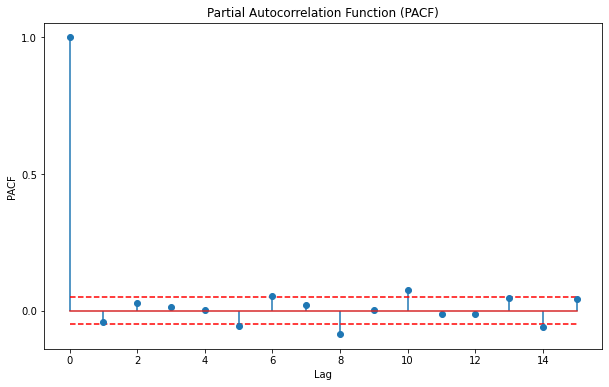

In [111]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming y_train_ar is your training data
lags = 15  # You can adjust the number of lags you want to inspect
pacf_values = sm.tsa.stattools.pacf(y_train_ar, nlags=lags)

# Plotting the PACF
plt.figure(figsize=(10, 6))
plt.stem(range(len(pacf_values)), pacf_values, use_line_collection=True)
plt.hlines([0.05, -0.05], xmin=0, xmax=lags, colors='r', linestyles='dashed')  # Significance lines
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.yticks([0, 0.5, 1])
plt.show()


    Original ETH_Price  Predicted ETH_Price
0            -0.033473            -0.028518
1            -0.004063            -0.002500
2            -0.004030            -0.013844
3            -0.006257             0.017991
4             0.000000             0.003251
..                 ...                  ...
95            0.027255             0.035204
96           -0.021927            -0.011313
97           -0.001079            -0.002303
98            0.002371             0.010170
99            0.023739             0.030723

[100 rows x 2 columns]


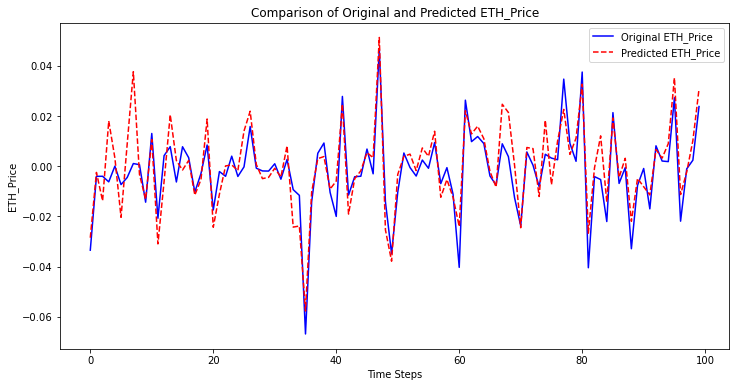

In [67]:
import matplotlib.pyplot as plt

mean_eth_price = scaler.mean_[df_returns.columns.get_loc('ETH_Price')]
std_eth_price = scaler.scale_[df_returns.columns.get_loc('ETH_Price')]
predictions_original_scale = [p * std_eth_price + mean_eth_price for p in predictionsLasso]

# Extract actuals from df_returns (already in original scale)
actuals = df_returns['ETH_Price'].iloc[start:].values

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Original ETH_Price': actuals,
    'Predicted ETH_Price': predictions_original_scale
})

# Print the comparison DataFrame
print(comparison_df)

# Plotting the comparison
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Original ETH_Price'].values, label='Original ETH_Price', color='blue')
plt.plot(comparison_df['Predicted ETH_Price'].values, label='Predicted ETH_Price', color='red', linestyle='--')
plt.title('Comparison of Original and Predicted ETH_Price')
plt.xlabel('Time Steps')
plt.ylabel('ETH_Price')
plt.legend()
plt.show()